In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
np.random.seed(42)


## Data 

In [4]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

## Uppdelning av data.

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [5]:
# Fördelningen 

print(f"Träningsdata: {X_train.shape}, {y_train.shape}")
print(f"Valideringsdata: {X_val.shape}, {y_val.shape}")
print(f"Testdata: {X_test.shape}, {y_test.shape}")

Träningsdata: (50000, 784), (50000,)
Valideringsdata: (10000, 784), (10000,)
Testdata: (10000, 784), (10000,)


## Modelering

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardisera bilderna
    ('model' , RandomForestClassifier())
])

param_grid = [
    #{'model': [RandomForestClassifier()],
     #'model__n_estimators': [10, 50, 100],
     #'model__max_depth': [None, 10, 20]},
     
     #{'model': [LinearSVC()],
     #'model__C': [0.1, 1, 1.5],
     #'model__max_iter': [5000],
     #'model__dual': [False]},

     {'model': [XGBClassifier()], 
     'model__n_estimators': [500, 550], 
     'model__learning_rate': [0.1, 0.2, 0.3]}
]

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy")

In [10]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', RandomForestClassifier())]),
             param_grid=[{'model': [XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types...
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=None, ...)],
                          'model__learning_rate': [0.2],
                          'model__n_estimators': [500, 550]}],
             scoring='accuracy')

In [11]:
grid_search.best_params_

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 'model__learning_rate': 0.2,
 'model__n_estimators': 500}

In [12]:
best_model = grid_search.best_estimator_

## Prediktion på valideringsdata.

In [49]:
#Prediktion på valideringsdata
y_val_pred = best_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)

print('Accuracy på valideringsdata:', accuracy_val)

Accuracy på valideringsdata: 0.9805


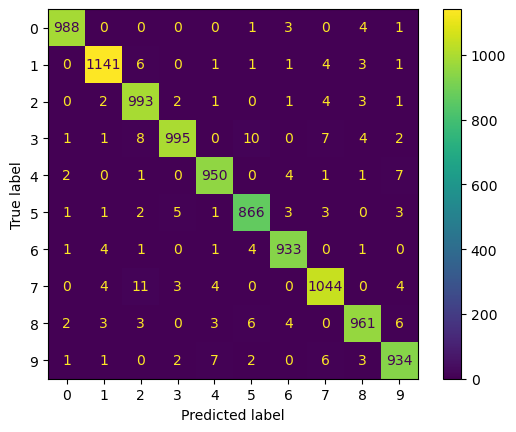

In [51]:
cm_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm_val).plot()

## Prediktion på testdata.

Accuracy på testdata: 0.9777


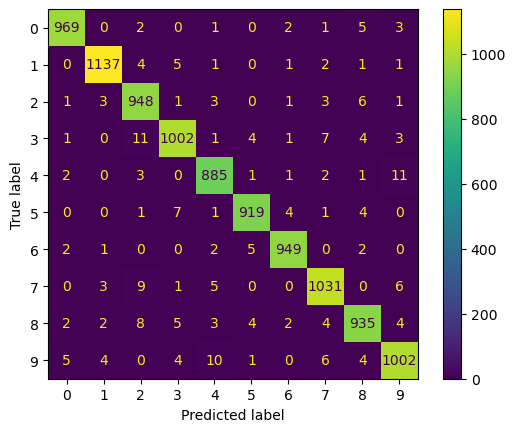

In [53]:
y_test_pred = best_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)

print('Accuracy på testdata:', accuracy_test)

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test).plot()

## Utvärdering

In [55]:
print('Accuracy på valideringsdata:', accuracy_val)
print('Accuracy på testdata:', accuracy_test)

Accuracy på valideringsdata: 0.9805
Accuracy på testdata: 0.9777


### Eftersom accuracy på testdata är nära validerings accuracy visar det på att modellen generaliserar bra. 

## Modellen tränas om på både tränning och valideringsdata.

In [13]:
best_model.fit(X_train_val, y_train_val)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## Slutlig utvärdering på testdata.

In [ ]:
y_test_pred_final = best_model.predict(X_test)
accuracy_test_final = accuracy_score(y_test, y_test_pred_final)

print('Accuracy på testdata med fulltränad modell:', accuracy_test_final)

## Spara modellen

In [14]:
import joblib

# Spara modellen.
joblib.dump(best_model, "best_xgb_model.pkl")

# Sparad GridSearch 
joblib.dump(grid_search, "grid_search_results.pkl")

['grid_search_results.pkl']

In [15]:
scaler = best_model.named_steps['scaler'] # Hämta StandardScaler från pipelinen

joblib.dump(scaler, "scaler.pkl") # Spara scalern

['scaler.pkl']